In [ ]:
import tensorflow as tf
tf.__version__

'2.9.2'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Calory Estimation Project

/content/drive/MyDrive/Calory Estimation Project


In [ ]:
!pip install --upgrade pip 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 30.8 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


In [ ]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/drive/MyDrive/Calory Estimation Project/models/research
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 80.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.0/25.0 MB 65.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.6/636.6 kB 

In [ ]:
!pwd

/content/drive/MyDrive/Calory Estimation Project


In [ ]:
import io
import scipy.misc
import numpy as np
import six
import time
import glob

from tqdm import tqdm
import Food

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util


%matplotlib inline

In [ ]:
start_time = time.time()
tf.keras.backend.clear_session()
detect_fn = tf.saved_model.load('inference_graph/saved_model/')
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time: ' + str(elapsed_time) + 's')

Elapsed time: 42.12445592880249s


In [ ]:
PATH_TO_LABELS = 'training/labelmap.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path (this can be local or on colossus)

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)


In [ ]:
import glob
PATH_TO_TEST_IMAGES_DIR = 'Food_Dataset/test/*.jpg'
TEST_IMAGE_PATHS = glob.glob(PATH_TO_TEST_IMAGES_DIR)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [ ]:
def get_calory(output_dict):
    _ = output_dict.pop('num_detections', None)
    ind = output_dict['detection_scores'] > 0.5
    output_dict = {k: v[ind] for k,v in output_dict.items()}
    
    plate_length=33
    plate_width=26
    plate_area=plate_length*plate_width
    
    calories={}
    
    plate_index = np.where(output_dict['detection_classes'] == 12)[0]
    if len(plate_index) != 1:
        calories["Error"] = 'You can not have more than one plate in the image.'
        return calories
    
    masked_plate_pixels = output_dict.get('detection_masks')[plate_index].sum()
    pixels_per_inch_sq=masked_plate_pixels/plate_area
    
    
    for i in range(output_dict.get('detection_classes').shape[0]):
        masked_food_pixels=output_dict.get('detection_masks')[i].sum()
        class_name=category_index[output_dict.get('detection_classes')[i]]['name']
        if class_name=='Plate': continue
        real_food_area=masked_food_pixels/pixels_per_inch_sq
        calorie=int(Food.get_calorie(class_name,real_food_area))
        if class_name in calories: calories[class_name] += calorie
        else: calories[class_name] = calorie
            
    return calories

2it [00:15,  7.85s/it]


Elapsed time: 7.08419942855835 second per image


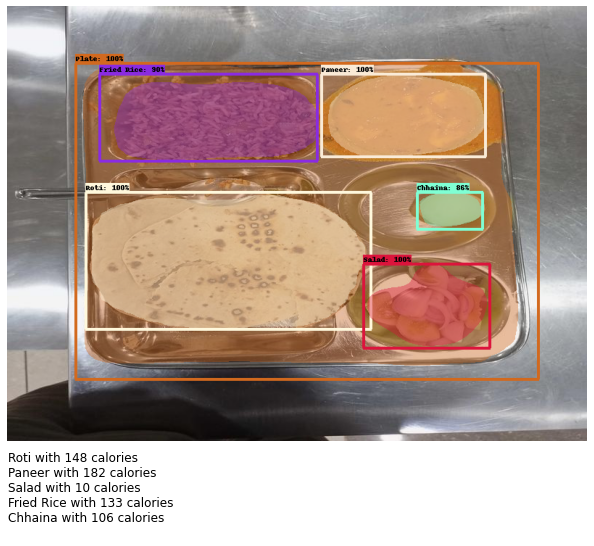

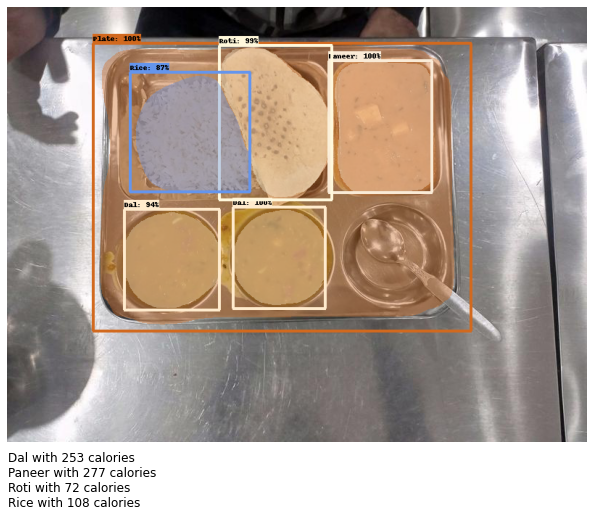

In [ ]:
import time


elapsed = []
for i, image_path in tqdm(enumerate(TEST_IMAGE_PATHS[5:7])):
  image_np = load_image_into_numpy_array(image_path)
  input_tensor = np.expand_dims(image_np, 0)
  start_time = time.time()
  detections = detect_fn(input_tensor)
  end_time = time.time()
  elapsed.append(end_time - start_time)

  plt.rcParams['figure.figsize'] = [42, 21]
  label_id_offset = 1
  image_np_with_detections = image_np.copy()

  

  detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(detections["detection_masks"][0], 
                                                                        detections["detection_boxes"][0],
                                                                        image_np.shape[0], image_np.shape[1])      
  detection_masks_reframed = tf.cast(detection_masks_reframed > 0.6, tf.uint8)
  detections["detection_masks_reframed"] = detection_masks_reframed.numpy()

  output_dict = {}
  output_dict["detection_boxes"] = np.asarray(detections["detection_boxes"][0])
  output_dict["detection_classes"] = np.asarray(detections["detection_classes"][0]).astype(np.int64)
  output_dict["detection_scores"] = np.asarray(detections["detection_scores"][0])
  output_dict["detection_masks"] = np.asarray(detections["detection_masks_reframed"])

  #count calories
  calories = get_calory(output_dict)
  text = ''
  for item, cal in calories.items():
    if item=='Error': text = item + ' : '+cal
    else: text += f'{item} with {cal} calories\n'

  viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        output_dict["detection_boxes"],
        output_dict["detection_classes"],
        output_dict["detection_scores"],
        category_index,
        instance_masks=output_dict["detection_masks"],

        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.40,
        agnostic_mode=False)
  
  fig = plt.figure(figsize=IMAGE_SIZE)
  ax = fig.gca()
  ax.grid(False)
  plt.imshow(image_np_with_detections)
  plt.axis('off')
  plt.text(0, 630+len(calories)*20, s = text, wrap=False, horizontalalignment='left', fontsize=12)

mean_elapsed = sum(elapsed) / float(len(elapsed))
print('Elapsed time: ' + str(mean_elapsed) + ' second per image')